<a href="https://colab.research.google.com/github/KINGSTING/CSC173-DeepCV-Lumingkit/blob/main/Sugarcane_CNN_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cell 1: Install & Download Data**

In [32]:
!pip install kagglehub
!pip install rembg[gpu] -q
!pip install ultralytics -q

import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Download latest version
print("Downloading dataset...")
path = kagglehub.dataset_download("nirmalsankalana/sugarcane-leaf-disease-dataset")

print("Path to dataset files:", path)

# Check what is inside the folder to ensure it downloaded correctly
print("\nFolders inside dataset:", os.listdir(path))

Using Colab cache for faster access to the 'sugarcane-leaf-disease-dataset' dataset.
Path to dataset files: /kaggle/input/sugarcane-leaf-disease-dataset

Folders inside dataset: ['Yellow', 'Mosaic', 'Healthy', 'RedRot', 'Rust']


**Cell 2: Data Generators (Preprocessing)**

In [33]:
import tensorflow as tf

# We define where our data is. Change this path to where you uploaded your folder.
DATASET_PATH = path

# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# --- 1. Create Datasets (Modern API) ---
# label_mode='categorical' ensures it works with your existing model setup.
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False # <--- CRITICAL FIX FOR EVALUATION
)

# Get Class Names
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# --- 2. Normalization & Optimization ---
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply mapping (But keep val_ds NOT shuffled for the confusion matrix)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.
Found 2521 files belonging to 5 classes.
Using 504 files for validation.
Classes found: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


**Cell 3: Build the Model (Hybrid Deep Learning)**

In [34]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Load MobileNetV2 (Pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base

# 2. Add Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# 3. Compile
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("✅ MobileNetV2 Model Ready. Starting Training...")

/tmp/ipython-input-3820639506.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


✅ MobileNetV2 Model Ready. Starting Training...


**Cell 4: Train the Model (CRITICAL STEP)**

In [35]:
# Updated Training Cell
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.2785 - loss: 1.9108 - val_accuracy: 0.4107 - val_loss: 1.3086
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.4425 - loss: 1.3165 - val_accuracy: 0.5000 - val_loss: 1.1917
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5560 - loss: 1.1343 - val_accuracy: 0.5496 - val_loss: 1.0973
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.6359 - loss: 0.9989 - val_accuracy: 0.6528 - val_loss: 0.9350
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6453 - loss: 0.9278 - val_accuracy: 0.6627 - val_loss: 0.8950
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.6825 - loss: 0.8360 - val_accuracy: 0.6885 - val_loss: 0.8472
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.7194 - loss: 0.7929 - val_accuracy: 0.7282 - val_loss: 0.7479
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.7237 - loss: 0.7207 - val_accuracy: 0

**Cell 5: Define Severity Calculator**

In [36]:
from ultralytics import FastSAM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Load the FastSAM model (Small version for speed)
# This downloads automatically (~40MB)
# Note: If this is the first run, it might take a moment to download weights.
seg_model = FastSAM('FastSAM-s.pt')

def calculate_severity(image_path, disease_type):
    # --- STEP 1: INSTANCE SEGMENTATION (FastSAM) ---
    # Run inference on the image
    results = seg_model(image_path, device='cuda' if torch.cuda.is_available() else 'cpu', conf=0.4, verbose=False)

    # Get the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for consistency
    img_h, img_w, _ = img.shape

    # Process the masks
    if results[0].masks is None:
        # Fallback if no masks found (return 0 severity)
        return 0.0, img

    masks = results[0].masks.data.cpu().numpy() # Get all masks as boolean arrays

    # --- STEP 2: SELECT THE "MAIN" LEAF ---
    # Heuristic: The target leaf is usually the Largest and closest to the Center.

    best_mask = None
    max_score = 0

    center_x, center_y = img_w // 2, img_h // 2

    for i, mask in enumerate(masks):
        # Resize mask to match image if needed (FastSAM sometimes outputs smaller masks)
        if mask.shape[:2] != (img_h, img_w):
            mask = cv2.resize(mask.astype(np.uint8), (img_w, img_h), interpolation=cv2.INTER_NEAREST)

        mask = mask.astype(bool) # Ensure boolean

        # 1. Calculate Area
        area = np.sum(mask)

        # 2. Calculate Center proximity
        # Find moments to get center of the mask
        M = cv2.moments(mask.astype(np.uint8))
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        dist_from_center = np.sqrt((cX - center_x)**2 + (cY - center_y)**2)

        # Scoring: Big area is good, far from center is bad
        # We normalize area by total image size
        norm_area = area / (img_w * img_h)
        norm_dist = dist_from_center / (np.sqrt(img_w**2 + img_h**2))

        # Score formula (Adjust weights if needed)
        score = norm_area - (0.5 * norm_dist)

        if score > max_score:
            max_score = score
            best_mask = mask.astype(np.uint8)

    if best_mask is None:
        # Fallback: Use the whole image if segmentation fails
        best_mask = np.ones((img_h, img_w), dtype=np.uint8)

    # --- STEP 3: COLOR ANALYSIS ON THE SELECTED MASK ---
    # Now we have a clean mask of JUST the main leaf.

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define Disease Colors
    if disease_type == 'Yellow':
        lower = np.array([15, 40, 40])
        upper = np.array([35, 255, 255])
    elif disease_type == 'RedRot':
        lower = np.array([0, 50, 50])
        upper = np.array([15, 255, 255])
    elif disease_type == 'Rust':
        lower = np.array([10, 80, 20])
        upper = np.array([25, 255, 200])
    elif disease_type == 'Mosaic':
        lower = np.array([35, 40, 40])
        upper = np.array([85, 255, 255])
    else:
        # Healthy
        return 0.0, img

    # Create Disease Mask (Raw)
    mask_disease_raw = cv2.inRange(hsv, lower, upper)

    # *** INTERSECTION ***
    # Disease = Color Match AND Inside Best Mask
    mask_final_disease = cv2.bitwise_and(mask_disease_raw, mask_disease_raw, mask=best_mask)

    # --- STEP 4: CALCULATE & VISUALIZE ---
    leaf_pixels = cv2.countNonZero(best_mask)
    disease_pixels = cv2.countNonZero(mask_final_disease)

    if leaf_pixels == 0:
        severity = 0
    else:
        severity = (disease_pixels / leaf_pixels) * 100

    # Visualization
    vis_img = img.copy()

    # Darken background (everything NOT in best_mask)
    # We use a numpy trick to darken indices where mask is 0
    bg_indices = (best_mask == 0)
    vis_img[bg_indices] = vis_img[bg_indices] // 4

    # Outline the selected leaf in Green
    contours_leaf, _ = cv2.findContours(best_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(vis_img, contours_leaf, -1, (0, 255, 0), 2)

    # Highlight disease in Red
    contours_dis, _ = cv2.findContours(mask_final_disease, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(vis_img, contours_dis, -1, (255, 0, 0), -1) # Filled red

    return severity, vis_img

print("✅ Instance-Aware Severity Module (FastSAM) Loaded.")

✅ Instance-Aware Severity Module (FastSAM) Loaded.


**Cell 6: Plot Training History**

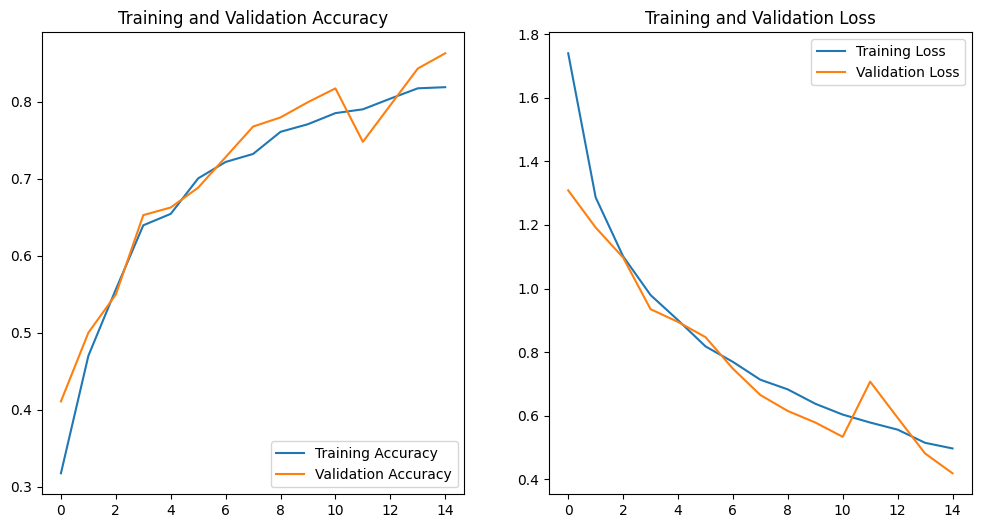

In [37]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Cell 7: Test with Uploaded Image**

⚙️ Initializing AI Systems...

⬇️ UPLOAD LEAF IMAGE FOR ANALYSIS ⬇️


Saving test4-sugarcane.jpg to test4-sugarcane (9).jpg

📄 Processing: test4-sugarcane (9).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
🧠 AI Diagnosis:  Yellow
📊 Confidence:    68.43%
⚠️ Status:        Diseased
   -> Initiating Advanced Severity Measurement...
📉 Severity:      17.02% (Moderate)
📋 Action:        Apply appropriate fungicide


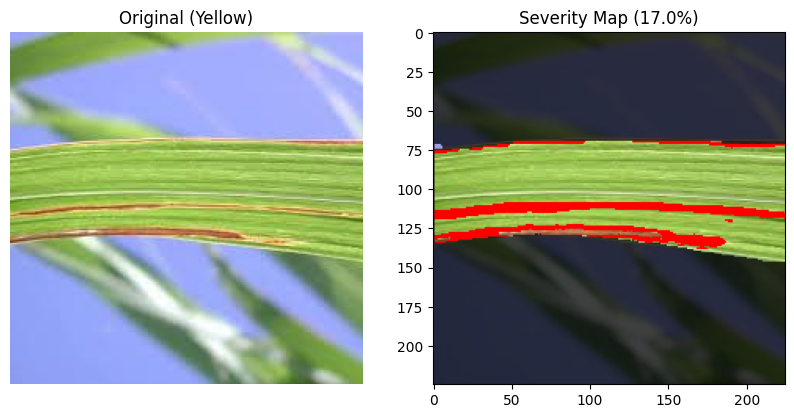

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tensorflow.keras.preprocessing import image as keras_image
from ultralytics import FastSAM
from google.colab import files

# --- 1. SETUP & INITIALIZATION ---
print("⚙️ Initializing AI Systems...")

# Load the "Specialist" (FastSAM for Severity)
# This handles the background removal and leaf isolation
seg_model = FastSAM('FastSAM-s.pt')

# Define Classes (Must match your training data)
class_labels = {0: 'Healthy', 1: 'Mosaic', 2: 'RedRot', 3: 'Rust', 4: 'Yellow'}

# Ensure the "Generalist" (MobileNet) is available
# If 'model' is not in memory, uncomment the next line to load it from file:
# from tensorflow.keras.models import load_model; model = load_model('sugarcane_disease_model.h5')

# --- 2. DEFINE SEVERITY CALCULATOR (The Unique Twist) ---
def measure_severity(image_path, disease_type):
    """
    Performs Instance Segmentation to find the main leaf,
    then uses HSV thresholding to calculate infection severity.
    """
    # A. Run FastSAM to find objects
    results = seg_model(image_path, device='cuda' if torch.cuda.is_available() else 'cpu', conf=0.4, verbose=False)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if results[0].masks is None:
        return 0.0, img # No leaf found

    # B. Find the "Main" Leaf (Largest & Central)
    masks = results[0].masks.data.cpu().numpy()
    best_mask = None
    max_score = 0
    center_x, center_y = w // 2, h // 2

    for mask in masks:
        mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
        area = np.sum(mask)
        # Calculate centrality
        M = cv2.moments(mask.astype(np.uint8))
        if M["m00"] != 0: cX, cY = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
        else: cX, cY = 0, 0
        dist = np.sqrt((cX - center_x)**2 + (cY - center_y)**2)

        # Score = Area - Distance Penalty
        score = area - (dist * 50)
        if score > max_score:
            max_score = score
            best_mask = mask.astype(np.uint8)

    if best_mask is None: return 0.0, img

    # C. Color Analysis (Specific to Disease)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    if disease_type == 'Yellow':
        lower = np.array([15, 40, 40]); upper = np.array([35, 255, 255])
    elif disease_type == 'RedRot':
        lower = np.array([0, 50, 50]); upper = np.array([15, 255, 255])
    elif disease_type == 'Rust':
        lower = np.array([10, 80, 20]); upper = np.array([25, 255, 200])
    elif disease_type == 'Mosaic':
        lower = np.array([35, 40, 40]); upper = np.array([85, 255, 255])
    else:
        return 0.0, img

    # Create Disease Mask
    mask_disease = cv2.inRange(hsv, lower, upper)

    # *** CRITICAL: Intersection of Disease AND Leaf ***
    mask_final = cv2.bitwise_and(mask_disease, mask_disease, mask=best_mask)

    # Calculate Ratio
    leaf_px = cv2.countNonZero(best_mask)
    dis_px = cv2.countNonZero(mask_final)
    severity = (dis_px / leaf_px) * 100 if leaf_px > 0 else 0

    # D. Visualization
    vis_img = img.copy()
    # Darken background
    vis_img[best_mask == 0] = vis_img[best_mask == 0] // 4
    # Outline Disease
    contours, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(vis_img, contours, -1, (255, 0, 0), -1)

    return severity, vis_img

# --- 3. MAIN EXECUTION LOOP ---
print("\n⬇️ UPLOAD LEAF IMAGE FOR ANALYSIS ⬇️")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📄 Processing: {filename}...")

    # --- STAGE 1: DIAGNOSIS (MobileNetV2) ---
    # We use the original image context for classification
    img_load = keras_image.load_img(filename, target_size=(150, 150))
    img_array = keras_image.img_to_array(img_load)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    pred_idx = np.argmax(predictions[0])
    pred_label = class_labels[pred_idx]
    confidence = 100 * np.max(predictions[0])

    print(f"🧠 AI Diagnosis:  {pred_label}")
    print(f"📊 Confidence:    {confidence:.2f}%")

    # --- STAGE 2: ACTION LOGIC ---
    if pred_label == 'Healthy':
        print("✅ Status:        Healthy Plant")
        print("💡 Recommendation: No action needed.")

        plt.figure(figsize=(5, 5))
        plt.imshow(keras_image.load_img(filename))
        plt.title("Healthy Plant")
        plt.axis('off')
        plt.show()

    else:
        # If sick, run the Severity Specialist
        print("⚠️ Status:        Diseased")
        print("   -> Initiating Advanced Severity Measurement...")

        severity, vis_img = measure_severity(filename, pred_label)

        # Interpret Severity
        if severity < 5: grade = "Mild"; action = "Monitor closely"
        elif severity < 20: grade = "Moderate"; action = "Apply appropriate fungicide"
        else: grade = "Severe"; action = "Remove/Cull infected plant immediately"

        print(f"📉 Severity:      {severity:.2f}% ({grade})")
        print(f"📋 Action:        {action}")

        # Show the "Doctor's View"
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(keras_image.load_img(filename))
        plt.title(f"Original ({pred_label})")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(vis_img)
        plt.title(f"Severity Map ({severity:.1f}%)")

Generating predictions...
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step


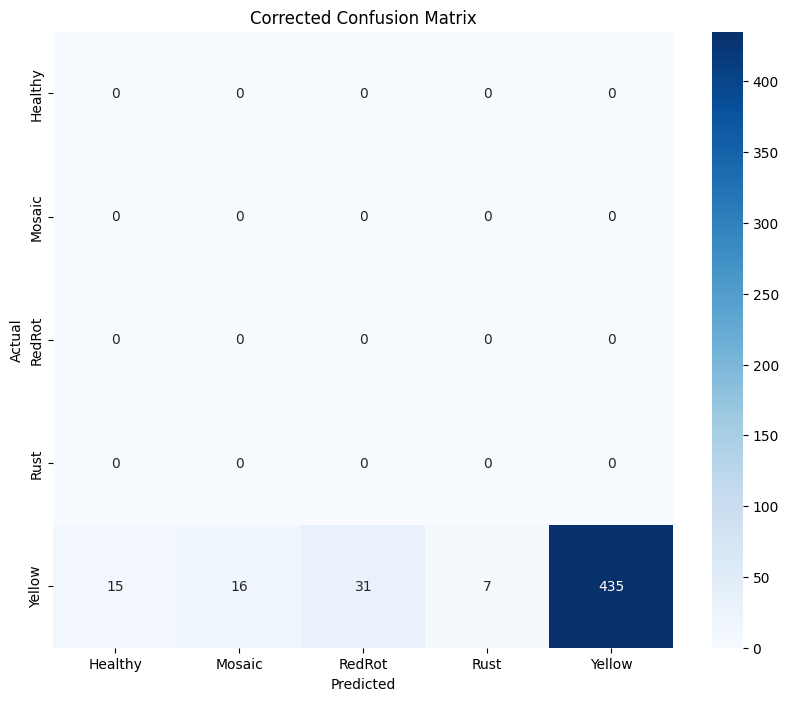

              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         0
      Mosaic       0.00      0.00      0.00         0
      RedRot       0.00      0.00      0.00         0
        Rust       0.00      0.00      0.00         0
      Yellow       1.00      0.86      0.93       504

    accuracy                           0.86       504
   macro avg       0.20      0.17      0.19       504
weighted avg       1.00      0.86      0.93       504



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Get Predictions
print("Generating predictions...")
# Note: val_ds is NOT shuffled now, so order is preserved
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Get True Labels
# Extract labels from the dataset (unbatch them first)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1) # Convert one-hot to index

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Corrected Confusion Matrix')
plt.show()

# 4. Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))